# Test on synthetic data

We evaluate the performance of the gridder on synthetic data produced by a visco-elastic model of the San Andreas Fault. We extract samples from the model grid and try to reconstruct the original grid using our interpolation method.

In [1]:
# Load required libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dask.distributed import Client, LocalCluster
import pyproj
import numpy as np
import pandas as pd
import xarray as xr
import itertools
import pickle
import verde as vd
# Load our custom gridder and utility functions
from vectorspline3d import VectorSpline3D, VectorSpline3DCV


## Load the synthetic

The synthetic data grid is stored in a netCDF file with all 3 components included and samples from this grid are in a CSV file. Load both of them so we can grid the samples and compare our results with the true synthetic grid.

In [2]:
with xr.open_dataset("../../data/synthetic-san-andreas-2017.nc") as ds:
    grid = ds.load()
print(grid)

<xarray.Dataset>
Dimensions:         (latitude: 251, longitude: 401)
Coordinates:
  * latitude        (latitude) float64 33.0 33.02 33.04 ... 37.96 37.98 38.0
  * longitude       (longitude) float64 -123.0 -123.0 -123.0 ... -115.0 -115.0
Data variables:
    east_velocity   (latitude, longitude) float64 nan nan nan ... 10.57 10.57
    north_velocity  (latitude, longitude) float64 nan nan nan ... -13.93 -13.94
    up_velocity     (latitude, longitude) float64 nan nan ... -0.02379 -0.02325
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        evel_2017.grd
    history:      grdsample vjunk.grd -Gevel_2017.grd -T
    GMT_version:  4.5.12 [64-bit]
    node_offset:  1


In [3]:
data = pd.read_csv("../../data/synthetic-san-andreas-2017-samples.csv")
data.describe()

,east_velocity,north_velocity,up_velocity,longitude,latitude
count,1769.000000,1769.000000,1769.000000,1769.000000,1769.000000
mean,-1.114175,1.785594,-0.000208,-118.549124,35.146060
std,8.585066,8.549163,0.222835,1.814692,1.353647
min,-14.090392,-14.346816,-0.904746,-122.500000,33.040000
25%,-9.798057,-6.769315,-0.119336,-120.160000,34.060000
50%,-1.169567,2.499222,0.013053,-118.280000,34.740000
75%,7.223662,8.807876,0.129990,-117.200000,36.160000
max,12.804050,16.630058,0.638053,-115.140000,37.980000


Extract the data region from the grid and set the grid spacing.

In [4]:
region = vd.get_region((grid.longitude.values, grid.latitude.values))
spacing = np.mean(grid.longitude[1:].values - grid.longitude[:-1].values)
print(region, spacing)

(-123.0, -115.0, 33.0, 38.0) 0.02


Create a mask to remove the grid points in the ocean from our grids using GMT.

In [5]:
region_str = "/".join(str(i) for i in region)
# Call out to the shell to generate the mask file
!gmt grdlandmask -Gsynthetic-landmask.nc -I$spacing -R$region_str
# Load it with xarray
with xr.open_dataset("synthetic-landmask.nc") as mask_ds:
    mask = mask_ds.rename(dict(lat="latitude", lon="longitude")).load()
# Now delete the temporary mask
!rm synthetic-landmask.nc
mask

gmt: /home/leo/miniconda3/lib/libcurl.so.4: no version information available (required by /home/leo/pkg/lib64/libgmt.so.6)


<xarray.Dataset>
Dimensions:    (latitude: 251, longitude: 401)
Coordinates:
  * longitude  (longitude) float64 -123.0 -123.0 -123.0 ... -115.0 -115.0 -115.0
  * latitude   (latitude) float64 33.0 33.02 33.04 33.06 ... 37.96 37.98 38.0
Data variables:
    z          (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
Attributes:
    Conventions:  CF-1.7
    history:      grdlandmask -Gsynthetic-landmask.nc -I0.02 -R-123.0/-115.0/...
    description:  Derived from the low resolution shorelines
    GMT_version:  6.0.0_9c729d4 [64-bit]

## Plot the synthetic data

Create a function that plots grids or data frames with vectors for the horizontal components and a pseudo-color map for the vertical.

In [6]:
def plot_data(data, ax=None, maxabs=3, every_arrow=8, quiver_scale=250, quiver_width=0.001, size=50):
    "Plot a grid or a DataFrame with the vertical in color and horizontal as vectors."
    crs = ccrs.Mercator()
    transform = ccrs.PlateCarree()
    if ax is None:
        plt.figure(figsize=(13, 16))
        ax = plt.subplot(111, projection=crs)
    cbargs = dict(orientation="horizontal", aspect=50, label="vertical velocity (mm/yr)",
                  shrink=0.8, pad=0.05)
    if isinstance(data, pd.DataFrame):
        tmp = ax.scatter(
            data.longitude, data.latitude, s=size, c=data.up_velocity,
            vmin=-maxabs, vmax=maxabs, cmap="seismic", transform=transform
        )
        plt.colorbar(tmp, ax=ax, **cbargs)        
    else:
        data.up_velocity.plot.pcolormesh(
            ax=ax, vmin=-maxabs, vmax=maxabs, cmap="seismic", cbar_kwargs=cbargs, 
            add_labels=False, transform=transform, 
        )
        indexer = slice(None, None, every_arrow)
        # Downsample the arrows so we can actually see something
        data = data.isel(longitude=indexer, latitude=indexer)
    ax.quiver(data.longitude.values, data.latitude.values, 
              data.east_velocity.values, data.north_velocity.values, 
              scale=quiver_scale, width=quiver_width, transform=transform)
    ax.coastlines(resolution="50m", linewidth=1)
    # Set the proper ticks for a Cartopy map
    ax.set_xticks(np.arange(*region[:2], 1), crs=transform)
    ax.set_yticks(np.arange(*region[2:], 1), crs=transform)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.set_extent(region, crs=transform)
    return ax

Plot the synthetic grid and the samples.

/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


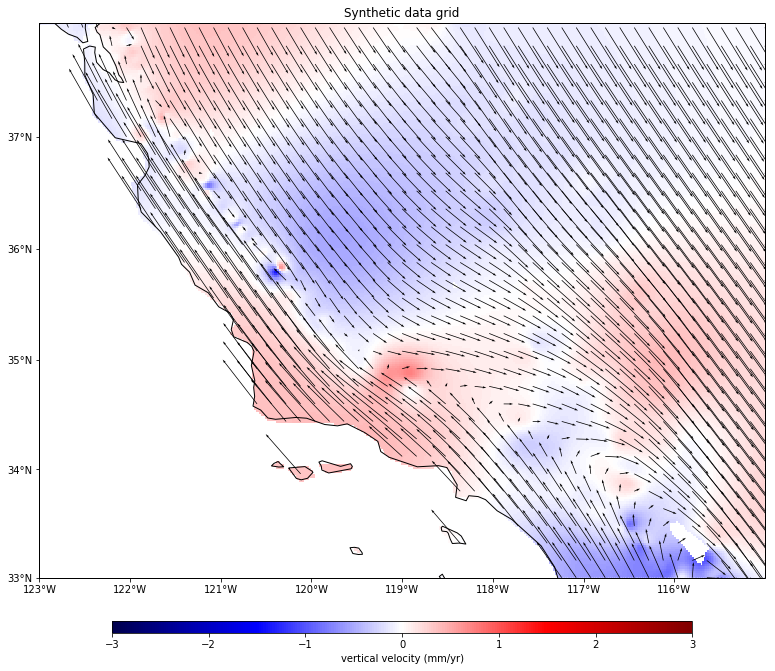

In [7]:
ax = plot_data(grid).set_title("Synthetic data grid")

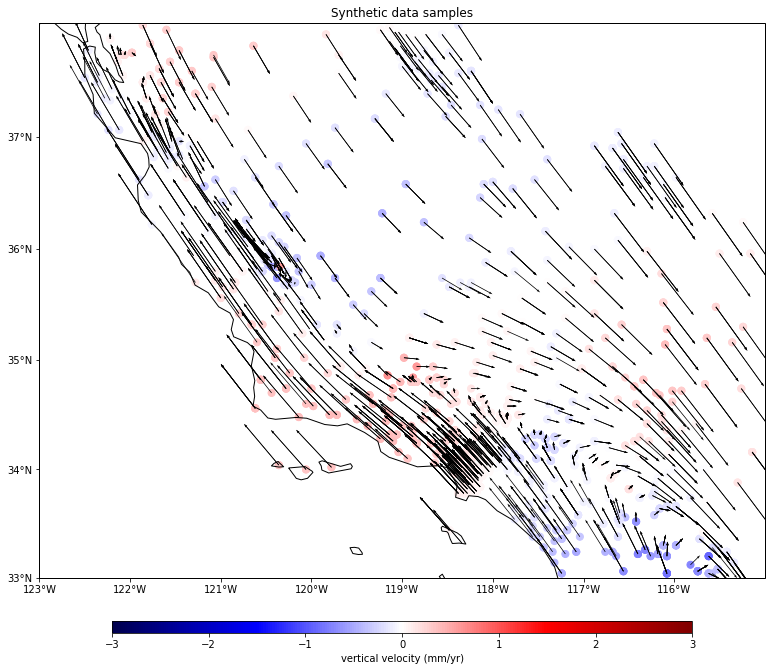

In [8]:
ax = plot_data(data).set_title("Synthetic data samples")

The gridder only operates on Cartesian data so we'll need to project the data coordinates before gridding.

In [9]:
coordinates = (data.longitude.values, data.latitude.values)
components = (data.east_velocity, data.north_velocity, data.up_velocity)
ndata = data.shape[0]
projection = pyproj.Proj(proj="aea", lon_0=data.longitude.mean())
proj_coords = projection(*coordinates)

## Force placement



A challenge is where to place the forces. Traditionally, forces are placed beneath each data point. This can lead to aliasing unless the data is first decimated using a blocked mean/median. What we can do instead is to use a blocked mean to determine force positions and number and keep the full dataset for fitting. Since the creeping part of the fault is known to cause problems for gridders, we'll give them a hand by adding extra forces along the fault.

In [10]:
blockmean = vd.BlockReduce(reduction=np.mean, spacing=spacing*111e3)
fault = vd.profile_coordinates((-120, 35.5), (-122, 37.5), size=100)[0]
fault_grid = vd.grid_coordinates([-122.5, -119.5, 35, 38], shape=(45, 45))
fault_mask = vd.distance_mask(fault, maxdist=0.15, coordinates=fault_grid)
fault_grid = projection(*[coord[fault_mask] for coord in fault_grid])
force_coords = blockmean.filter(
    tuple(np.concatenate([f[i].ravel() for f in [proj_coords, fault_grid]]) for i in range(2)),
    np.ones(ndata + fault_grid[0].size)
)[0]
print(force_coords[0].size)

788


Plot the force locations.

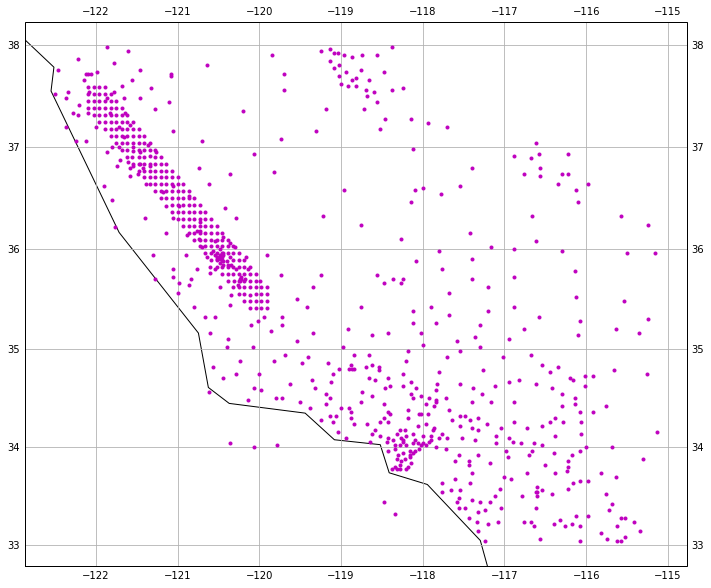

In [11]:
plt.figure(figsize=(16, 10))
ax = plt.subplot(111, projection=ccrs.Mercator())
plt.plot(*projection(*force_coords, inverse=True), "m.", transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.coastlines()

Save the force locations for later.

In [12]:
pd.DataFrame(
    data=np.transpose(projection(*force_coords, inverse=True)), 
    columns=["longitude", "latitude"]
).to_csv("../../data/synthetic-san-andreas-2017-force-coordinates.csv", index=False)

## Training and testing data

We'll use the samples as our trainning dataset for the gridder (we'll fit it to these data) and we'll evaluate the model performance using the original data grid (the testing dataset). The evaluation will be done by computing an R² score. With this in place, we'll be able to systematically search for the parameter configuration that best reproduces the original grid.

Before that, we need to deal with the issue of the different magnitudes of each data component.

In [13]:
print(np.linalg.norm(data.up_velocity)/np.linalg.norm(data.east_velocity))

0.025740111323276797


This means that an unweighted fit will favor the horizontal components at the expense of the vertical. We can use data weights to balance things out and make sure that the vertical is fitted as well.

In [14]:
weights = tuple(np.full(ndata, w) for w in [0.01, 0.01, 1])

Now we can create the training and testing sets for fitting.

In [15]:
train = (
    proj_coords, 
    components, 
    weights
)
grid_data = vd.grid_to_table(
    #vd.distance_mask((data.longitude, data.latitude), maxdist=0.5, grid=grid)
    grid
).dropna()
test = (
    projection(grid_data.longitude.values, grid_data.latitude.values),
    (grid_data.east_velocity, grid_data.north_velocity, grid_data.up_velocity)
)

## Fit the 3-component spline

This is a time consuming process and each step doesn't require that much memory. So we can run the grid search in parallel using Dask. We'll create a Dask client that uses a local cluster (running on this machine).

In [16]:
client = Client(LocalCluster(n_workers=2, threads_per_worker=2))
client

Client Scheduler: tcp://127.0.0.1:41941 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 8.35 GB


Since the train and test data are the same for each step, we can scatter them across the cluster once to avoid the transfer costs at every job.

In [17]:
train_future = client.scatter(train)
test_future = client.scatter(test)

The parallel client works by submitting jobs (fuctions) to a queue. We need to make a function that fits and scores a given gridder and returns the result.

In [18]:
def fit_score(estimator, train, test):
    "Function that we can submit as a Dask job to fit and score a gridder"
    return estimator.fit(*train).score(*test)

This is the parameter grid that we'll use to search for optimal configuration.

In [19]:
dampings = [0.0001, 0.001, 0.01, 0.1, 1]
depths = [1e3, 5e3, 10e3, 20e3, 30e3, 40e3, 50e3]
poissons = [-1, -0.5, 0, 0.25, 0.5]
couplings = [-1, -0.5, 0, 0.5, 1]

# Use itertools to create a list with all combinations of parameters to test
parameter_combinations = [
    dict(zip(["damping", "depth", "poisson", "coupling"], combo))
    for combo in itertools.product(dampings, depths, poissons, couplings)
]
print("Number of combinations:", len(parameter_combinations))

Number of combinations: 875


Now we can fit and score a gridder for each parameter combination and gather the R² scores.


In [20]:
%%time
scores = []
for params in parameter_combinations:
    candidate = VectorSpline3D(force_coords=force_coords, **params)
    scores.append(client.submit(fit_score, candidate, train_future, test_future))
scores = [i.result() for i in scores]
best = np.argmax(scores)
best_spline = parameter_combinations[best]
spline = VectorSpline3D(force_coords=force_coords, **best_spline)
spline.fit(*train)
print("Score on training set:", spline.score(*train))
print("Best score on testing set:", scores[best])
print("Best spline:", best_spline)

Score on training set: 0.9997931772006962
Best score on testing set: 0.9826909601488308
Best spline: {'damping': 0.01, 'depth': 1000.0, 'poisson': -0.5, 'coupling': 0}
CPU times: user 2min 40s, sys: 10.4 s, total: 2min 50s
Wall time: 18min 15s


## Generate a grid and compare with original

We can now generate a geographic grid and compare our results with the original grid. We'll save both the prediction and the differences to netCDF files.

In [21]:
grid_spl = spline.grid(
    region=region,
    spacing=spacing, 
    projection=projection,
    dims=["latitude", "longitude"],
    data_names=["east_velocity", "north_velocity", "up_velocity"]
).where(mask.z.values)
grid_spl = vd.distance_mask(coordinates, maxdist=50e3, grid=grid_spl, projection=projection)

diff_spl = grid - grid_spl
grid_spl.to_netcdf("../../data/synthetic-san-andreas-2017-3c-prediction.nc")
diff_spl.to_netcdf("../../data/synthetic-san-andreas-2017-3c-difference.nc")

grid_spl

<xarray.Dataset>
Dimensions:         (latitude: 251, longitude: 401)
Coordinates:
  * longitude       (longitude) float64 -123.0 -123.0 -123.0 ... -115.0 -115.0
  * latitude        (latitude) float64 33.0 33.02 33.04 ... 37.96 37.98 38.0
Data variables:
    east_velocity   (latitude, longitude) float64 nan nan nan ... nan nan nan
    north_velocity  (latitude, longitude) float64 nan nan nan ... nan nan nan
    up_velocity     (latitude, longitude) float64 nan nan nan ... nan nan nan
Attributes:
    metadata:  Generated by VectorSpline3D(coupling=0, damping=0.01, depth=10...

/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


Text(0.5, 1.0, 'Grid using 3-components')

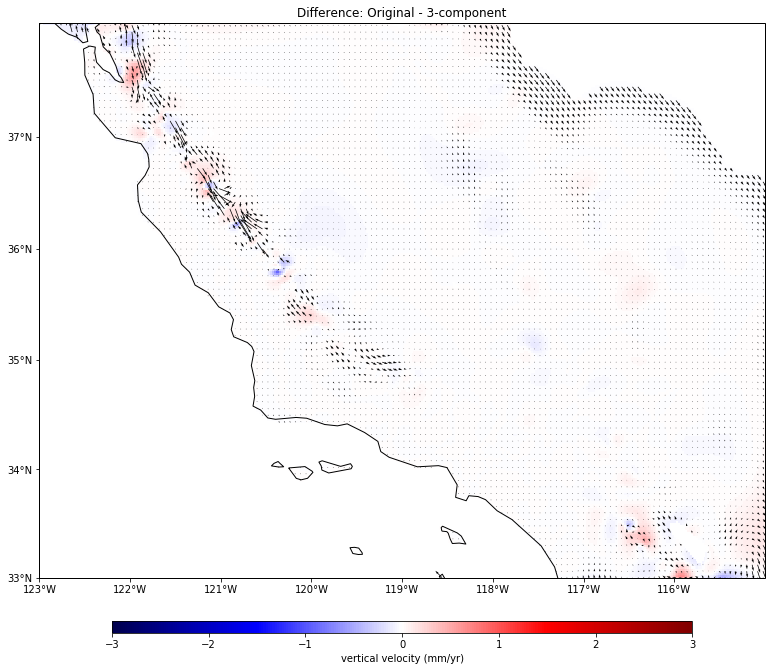

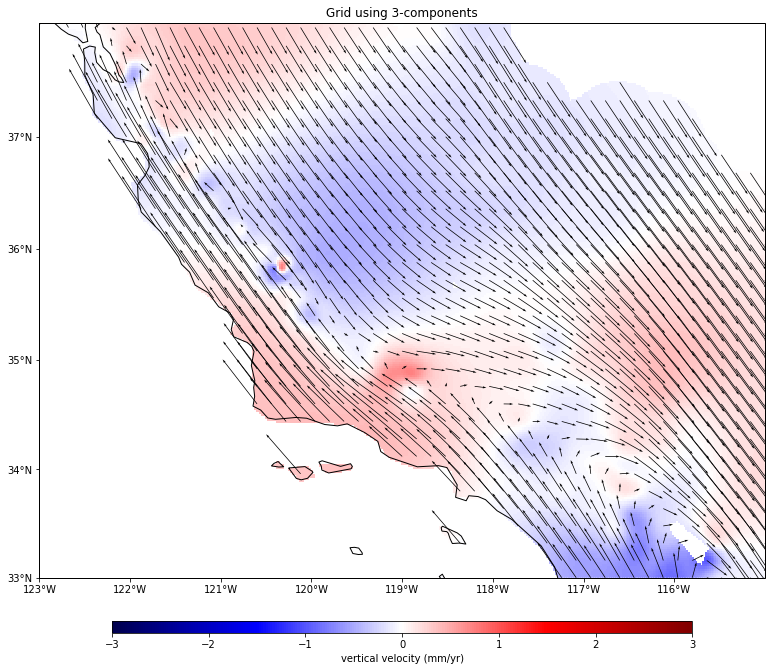

In [22]:
plot_data(diff_spl, every_arrow=3).set_title("Difference: Original - 3-component")
plot_data(grid_spl).set_title("Grid using 3-components")

Calculate the residuals with the original samples and save them to a CSV file.

In [23]:
residuals = [o - p for o, p in zip(components, spline.predict(proj_coords))]
residuals = dict(zip([c + "_velocity" for c in "east north up".split()], residuals))
residuals.update(dict(longitude=data.longitude, latitude=data.latitude))
residuals = pd.DataFrame(residuals)
residuals.to_csv("../../data/synthetic-san-andreas-2017-residuals.csv", index=False)
residuals.describe()

,east_velocity,north_velocity,up_velocity,longitude,latitude
count,1769.000000,1769.000000,1.769000e+03,1769.000000,1769.000000
mean,-0.000036,0.000019,-6.634149e-09,-118.549124,35.146060
std,0.136614,0.139454,2.241246e-03,1.814692,1.353647
min,-0.788434,-0.839273,-1.954759e-02,-122.500000,33.040000
25%,-0.023742,-0.023152,-3.959071e-05,-120.160000,34.060000
50%,0.000561,0.000594,-5.864824e-09,-118.280000,34.740000
75%,0.028040,0.024958,3.640221e-05,-117.200000,36.160000
max,1.089943,0.697744,2.989326e-02,-115.140000,37.980000


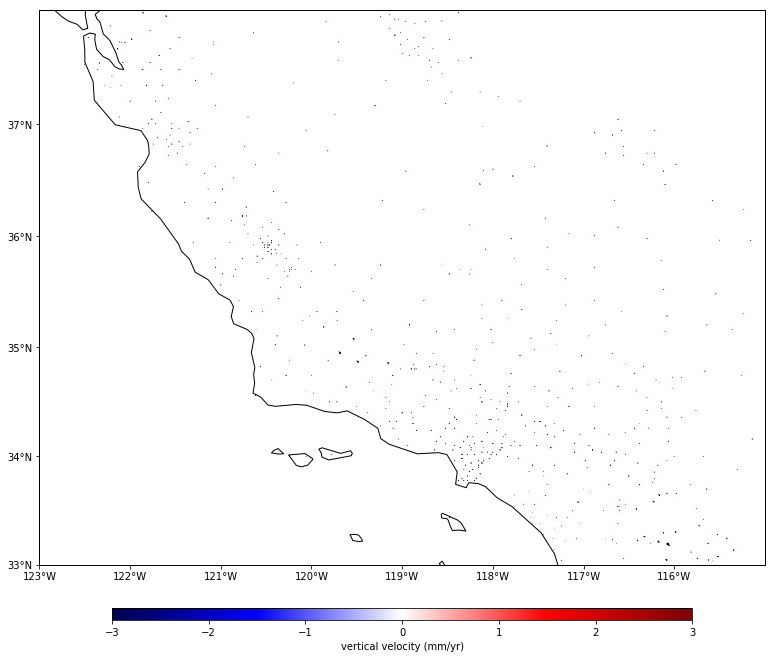

In [24]:
plot_data(residuals)

## Compare with the biharmonic spline

We'll compare the performance of our method using 3 single-component splines. To be fair, the regulatization parameter for these splines will also be chosen through cross-validation and we'll use the same force locations. We won't use the weights for these splines because they don't need it.

In [25]:
%%time
dampings = [None, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
mindists = [1e3, 10e3, 25e3, 50e3, 75e3, 100e3, 110e3, 120e3, 130e3, 140e3, 150e3]

parameter_combinations = [
    dict(zip(["damping", "mindist"], combo))
    for combo in itertools.product(dampings, mindists)
]
print("Number of combinations:", len(parameter_combinations))

scores = []
for params in parameter_combinations:
    candidate = vd.Vector([
        vd.Spline(force_coords=force_coords, **params) for i in range(3)
    ])
    scores.append(client.submit(fit_score, candidate, train_future[:2], test_future))
scores = [i.result() for i in scores]

best = np.argmax(scores)
best_spline_single = parameter_combinations[best]
spline_single = vd.Vector([
        vd.Spline(force_coords=force_coords, **best_spline_single)
        for i in range(3)
])
spline_single.fit(*train[:2])

print("Score on training set:", spline_single.score(*train))
print("Best score on testing set:", scores[best])
print("Best parameters:", best_spline_single)

Number of combinations: 66
Score on training set: 0.9999999950960631
Best score on testing set: 0.9833141303953822
Best parameters: {'damping': 1e-07, 'mindist': 150000.0}
CPU times: user 30.1 s, sys: 3.05 s, total: 33.2 s
Wall time: 4min 6s


Now we can predict the grid and compare the results with the coupled interpolation.

In [26]:
grid_spl_single = spline_single.grid(
    region=region,
    spacing=spacing, 
    projection=projection,
    dims=["latitude", "longitude"],
    data_names=["east_velocity", "north_velocity", "up_velocity"]
).where(mask.z.values)
grid_spl_single = vd.distance_mask(coordinates, maxdist=50e3, grid=grid_spl_single, projection=projection)

diff_spl_single = grid - grid_spl_single
grid_spl_single.to_netcdf("../../data/synthetic-san-andreas-2017-1c-prediction.nc")
diff_spl_single.to_netcdf("../../data/synthetic-san-andreas-2017-1c-difference.nc")

grid_spl_single

<xarray.Dataset>
Dimensions:         (latitude: 251, longitude: 401)
Coordinates:
  * longitude       (longitude) float64 -123.0 -123.0 -123.0 ... -115.0 -115.0
  * latitude        (latitude) float64 33.0 33.02 33.04 ... 37.96 37.98 38.0
Data variables:
    east_velocity   (latitude, longitude) float64 nan nan nan ... nan nan nan
    north_velocity  (latitude, longitude) float64 nan nan nan ... nan nan nan
    up_velocity     (latitude, longitude) float64 nan nan nan ... nan nan nan
Attributes:
    metadata:  Generated by Vector(components=[Spline(damping=1e-07, engine='...

/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


Text(0.5, 1.0, 'Difference: Original - 3-component')

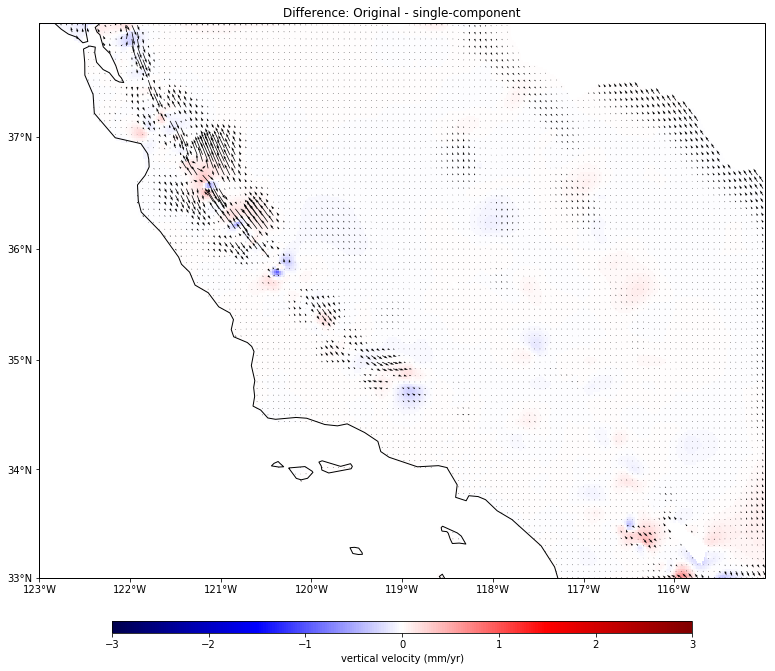

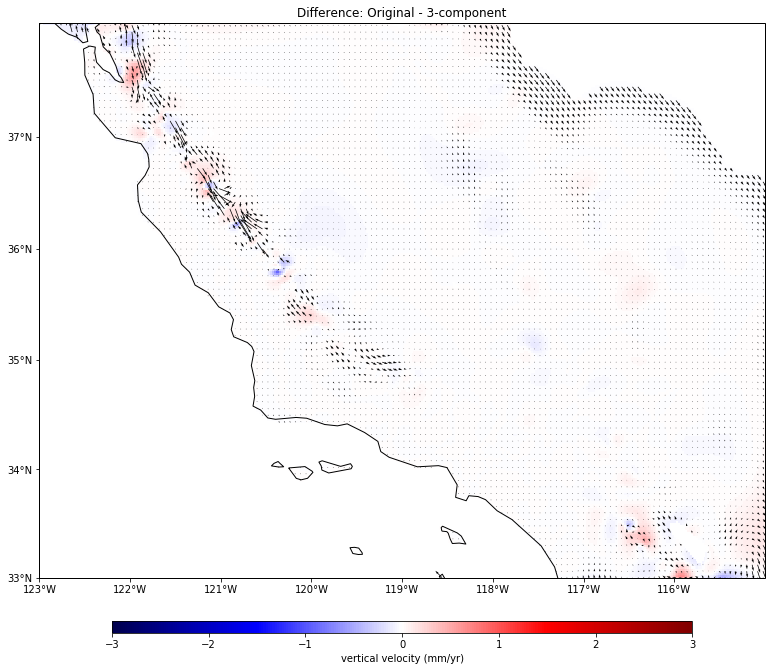

In [27]:
plot_data(diff_spl_single, every_arrow=3).set_title("Difference: Original - single-component")
plot_data(diff_spl, every_arrow=3).set_title("Difference: Original - 3-component")

[]()